In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.io.ascii import read
import fitsio

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def medxbin(x,y,binsize,minpts=20,xmin=None,xmax=None):
    """
    Compute the median (and other statistics) in fixed bins along the x-axis.
    """
    import numpy as np
    from scipy import ptp

    # Need an exception if there are fewer than three arguments.

    if xmin==None:
        xmin = x.min()
    if xmax==None:
        xmax = x.max()
    #print(xmin,xmax)

    nbin = int(ptp(x)/binsize)
    bins = np.linspace(xmin,xmax,nbin)
    idx  = np.digitize(x,bins)
    #print(nbin, bins, xmin, xmax)

    stats = np.zeros(nbin,[('median','f8'),('sigma','f8'),('iqr','f8')])
    for kk in np.arange(nbin):
        npts = len(y[idx==kk])
        if npts>minpts:
            stats['median'][kk] = np.median(y[idx==kk])
            stats['sigma'][kk] = np.std(y[idx==kk])
            stats['iqr'][kk] = np.subtract(*np.percentile(y[idx==kk],[75, 25]))

    # Remove bins with too few points.
    good = np.nonzero(stats['median'])
    stats = stats[good]

    return bins[good], stats

### Reading in data and making preliminary cuts.

In [3]:
pypath = os.path.join(os.sep, 'global', 'work', 'projects', 'legacysurvey', 'legacycentrals')
meertcat = os.path.join(pypath, 'meert_et_al_data_tables_v2')
mendelcat = os.path.join(pypath, 'UPenn_PhotDec_Mstar_mlMendel14.dat')
wisccat = os.path.join(pypath, 'UPenn_PhotDec_Mstar_mlPCAWiscM11.dat')

In [4]:
rmpath = os.path.join(os.sep, 'global', 'work', 'projects', 'redmapper')
rmcatfile = os.path.join(rmpath, 'redmapper_isedfit_v5.10_centrals.fits.gz')

#### Tab3 includes the effects of dust, while Tab5 does not.

In [5]:
# Read the Mendel catalog
columns = ('GalCount', 'FlagSerExp', 'Mstar_Tab5_Pymorph',
           'Mstar_Tab5_Truncated', 'Mstar_Tab3_Pymorph',
           'Mstar_Tab3_Truncated', 'Mstar_Tab5_Mendel',
           'Mstar_Tab3_Mendel', 'Mstar_Tab5_cModel',
           'Mstar_Tab3_cModel')
dtype = np.dtype([(col, np.float) for col in columns])
allmendel = np.loadtxt(mendelcat, dtype=dtype)
#allmendel.dtype.names

In [6]:
# Keep good measurements and data.
keep = (np.where(allmendel['FlagSerExp'] == 0) and np.where(allmendel['Mstar_Tab5_Pymorph'] > 0))[0]
print('Keeping {} / {} measurements in the Mendel catalog.'.format(len(keep), len(allmendel)))
mendel = allmendel[keep]

Keeping 654801 / 670722 measurements in the Mendel catalog.


In [7]:
# Read the parent Meert catalog to get ra, dec and other info.
#upennpath = os.path.join(pypath, 'meert_et_al_data_tables_v2')
upenncatfile = os.path.join(meertcat, 'UPenn_PhotDec_CAST.fits')
upenncat = fitsio.read(upenncatfile, ext=1, rows=keep, upper=True)
#upenncat.dtype.names
len(upenncat)

654801

In [8]:
#len(mendel)

In [9]:
np.all((upenncat['GALCOUNT'], mendel['GalCount']))
# Great! That means Mendel and UPennCat are matched. Not we can use cuts on RA/DEC in UPennCat to cut Mendel masses.

True

In [10]:
rminfo = fitsio.FITS(rmcatfile)
rmcat = rminfo[1].read(columns=['Z', 'RA', 'DEC', 'LAMBDA_CHISQ', 'MSTAR_50', 'MSTAR_ERR', 'IMAG'])
print(rminfo[1])


  file: /global/work/projects/redmapper/redmapper_isedfit_v5.10_centrals.fits.gz
  extension: 1
  type: BINARY_TBL
  rows: 407118
  column info:
    MEM_MATCH_ID        i4  
    Z                   f4  
    RA                  f8  
    DEC                 f8  
    R                   f4  
    P                   f4  
    PFREE               f4  
    THETA_I             f4  
    THETA_R             f4  
    IMAG                f4  
    IMAG_ERR            f4  
    ZRED                f4  
    ZRED_E              f4  
    ZRED_CHISQ          f4  
    BCG_SPEC_Z          f4  
    Z_SPEC_INIT         f4  
    Z_INIT              f4  
    LAMBDA_CHISQ        f4  
    LAMBDA_CHISQ_E      f4  
    LAMBDA_ZRED         f4  
    LAMBDA_ZRED_E       f4  
    R_LAMBDA            f4  
    SCALEVAL            f4  
    MASKFRAC            f4  
    C_LAMBDA            f4  array[4]
    C_LAMBDA_ERR        f4  array[4]
    MAG_LAMBDA_ERR      f4  array[5]
    CHISQ               f4  
    Z_LAMBDA      

In [11]:
from astropy.coordinates import SkyCoord
from astropy import units as u

In [12]:
rcoord = SkyCoord(ra=rmcat['RA']*u.degree, dec=rmcat['DEC']*u.degree)
penncoord = SkyCoord(ra=upenncat['RA']*u.degree, dec=upenncat['DEC']*u.degree)
idx, sep2d, dist3d = rcoord.match_to_catalog_sky(penncoord, nthneighbor=1)

In [13]:
gd = np.where(sep2d < 3 * u.arcsec)[0]
len(gd)

23599

### Inspecting the catalogs.

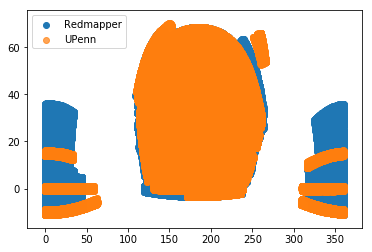

In [14]:
fig, ax = plt.subplots()
ax.scatter(rmcat['RA'], rmcat['DEC'], label='Redmapper')
ax.scatter(upenncat['RA'], upenncat['DEC'], alpha=0.7, label='UPenn')
ax.legend(loc='upper left')

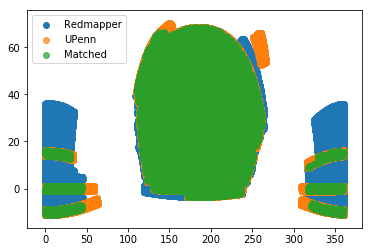

In [15]:
fig, ax = plt.subplots()
ax.scatter(rmcat['RA'], rmcat['DEC'], label='Redmapper')
ax.scatter(upenncat['RA'], upenncat['DEC'], alpha=0.7, label='UPenn')
ax.scatter(upenncat['RA'][idx[gd]], upenncat['DEC'][idx[gd]], alpha=0.7, label='Matched')
ax.legend(loc='upper left')

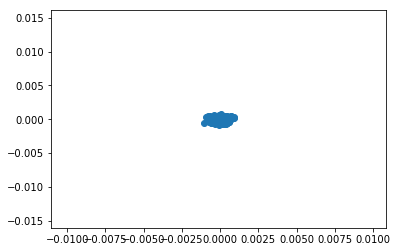

In [16]:
plt.scatter(rmcat['RA'][gd] - upenncat['RA'][idx[gd]], rmcat['DEC'][gd] - upenncat['DEC'][idx[gd]])

In [17]:
(rmcat['RA'] - upenncat[idx]['RA']) * 3600

array([   1.21145462,   88.37902542,  -46.95989881, ..., -295.143147  ,
        -84.02245114, -111.28514995])

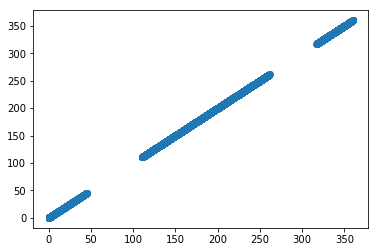

In [18]:
fig, ax = plt.subplots()
plt.scatter(rmcat['RA'][gd], upenncat['RA'][idx[gd]])

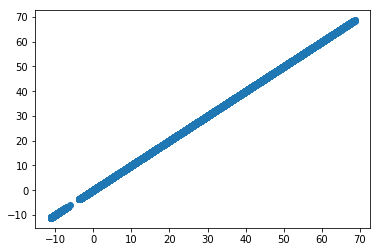

In [19]:
fig, ax = plt.subplots()
plt.scatter(rmcat['DEC'][gd], upenncat['DEC'][idx[gd]])

### PyMorph/Mendel vs. RedMaPPer Stellar Masses

[ 1.01699777 -0.13972866]


/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


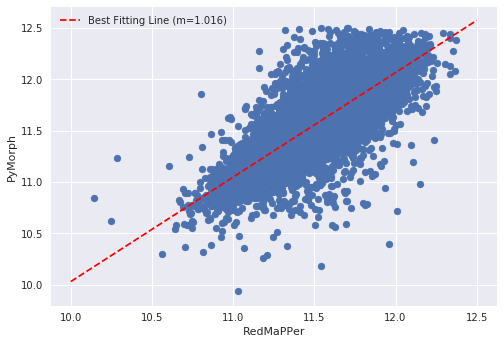

In [20]:
import seaborn as sns
fig, ax = plt.subplots()
plt.scatter(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab5_Pymorph'][idx[gd]])
qq = np.polyfit(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab5_Pymorph'][idx[gd]], 1)
xx = np.linspace(10, 12.5, 1000)
plt.plot(xx, xx*qq[0]+qq[1], 'r--', label='Best Fitting Line (m=1.016)')
print(qq)
plt.xlabel('RedMaPPer')
plt.ylabel('PyMorph')
plt.legend()

In [21]:
qq, cov = np.polyfit(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab5_Pymorph'][idx[gd]], 1, cov=True)
error = np.sqrt(np.diag(cov))
print(error)

[ 0.00454551  0.05238261]


/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


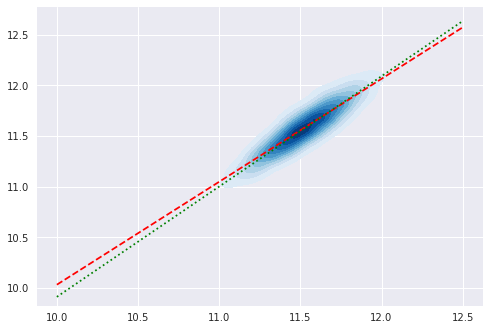

In [22]:
sns.kdeplot(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab5_Pymorph'][idx[gd]],
            cmap="Blues", shade=True, shade_lowest=False)
plt.plot(xx, xx*qq[0]+qq[1], 'r--', label='Best Fitting Line (m=1.016)')
plt.plot(xx, xx*1.09-0.99, 'g:', label='Best Fitting Line (m=adjusted by eye)')

[ 0.94430402  0.65816547]
[ 0.00454419  0.05236735]


/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


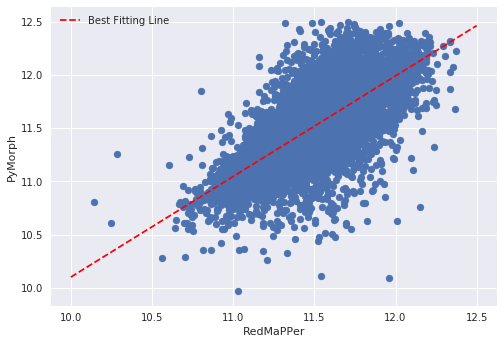

In [23]:
plt.scatter(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab3_Pymorph'][idx[gd]])
mm, cov = np.polyfit(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab3_Pymorph'][idx[gd]], 1, cov=True)
xx = np.linspace(10, 12.5, 1000)
plt.plot(xx, xx*mm[0]+mm[1], 'r--', label='Best Fitting Line')
print(mm)
plt.xlabel('RedMaPPer')
plt.ylabel('PyMorph')
plt.legend()
error = np.sqrt(np.diag(cov))
print(error)

[ 0.88782306  1.32048232]
[ 0.00394692  0.04548441]


/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


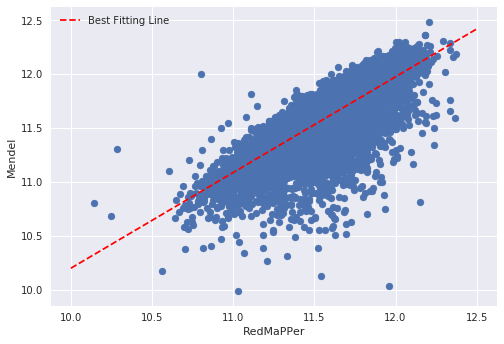

In [24]:
plt.scatter(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab3_Mendel'][idx[gd]])
pp, cov = np.polyfit(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab3_Mendel'][idx[gd]], 1, cov=True)
xx = np.linspace(10, 12.5, 1000)
plt.plot(xx, xx*pp[0]+pp[1], 'r--', label='Best Fitting Line')
print(pp)
plt.xlabel('RedMaPPer')
plt.ylabel('Mendel')
plt.legend()
error = np.sqrt(np.diag(cov))
print(error)

[ 0.96051681  0.52258819]
[ 0.00383081  0.04414637]


/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


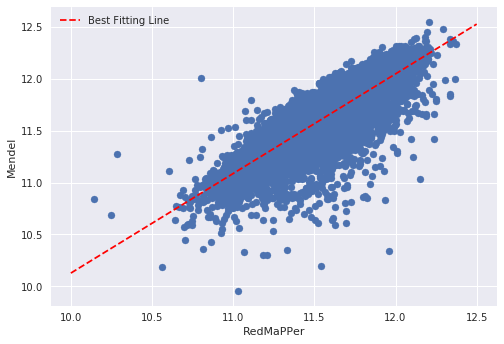

In [25]:
plt.scatter(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab5_Mendel'][idx[gd]])
tt, cov = np.polyfit(rmcat['MSTAR_50'][gd], mendel['Mstar_Tab5_Mendel'][idx[gd]], 1, cov=True)
xx = np.linspace(10, 12.5, 1000)
plt.plot(xx, xx*tt[0]+tt[1], 'r--', label='Best Fitting Line')
print(tt)
plt.xlabel('RedMaPPer')
plt.ylabel('Mendel')
plt.legend()
error = np.sqrt(np.diag(cov))
print(error)

/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


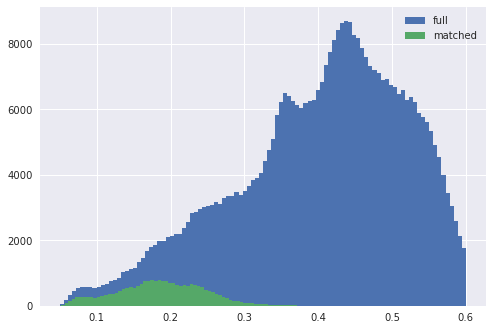

In [26]:
_ = plt.hist(rmcat['Z'], bins=100, label='full')
_ = plt.hist(rmcat['Z'][gd], bins=100, label='matched')
plt.legend()

/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


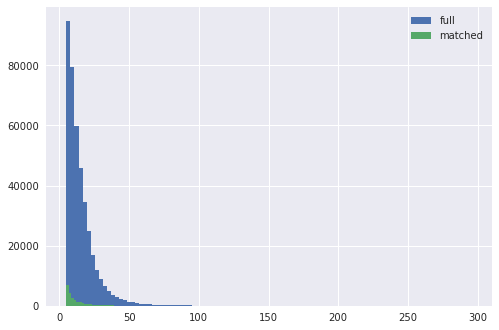

In [27]:
_ = plt.hist(rmcat['LAMBDA_CHISQ'], bins=100, label='full')
_ = plt.hist(rmcat['LAMBDA_CHISQ'][gd], bins=100, label='matched')
plt.legend()

/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


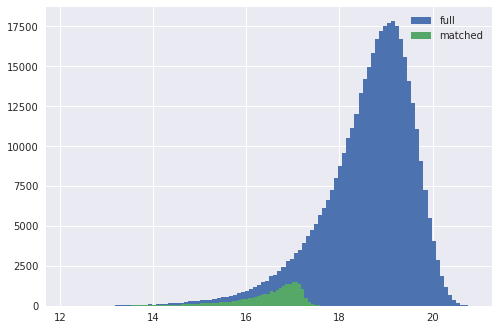

In [28]:
_ = plt.hist(rmcat['IMAG'], bins=100, label='full')
_ = plt.hist(rmcat['IMAG'][gd], bins=100, label='matched')
plt.legend()

(0, 25)

/usr/local/anaconda3/envs/py35/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


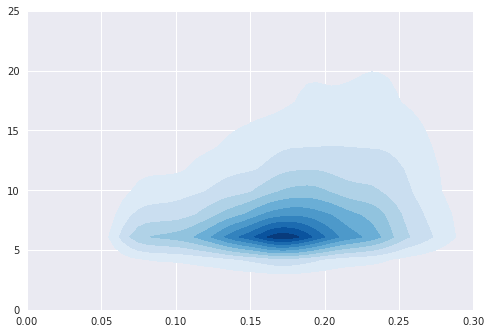

In [29]:
sns.kdeplot(rmcat['Z'][gd], rmcat['LAMBDA_CHISQ'][gd],
            cmap="Blues", shade=True, shade_lowest=False)
plt.xlim(0,0.3)
plt.ylim(0,25)

# Residuals

In [30]:
blah = medxbin(rmcat['MSTAR_50'][gd]-mendel['Mstar_Tab5_Mendel'][idx[gd]], mendel['Mstar_Tab5_Mendel'][idx[gd]],0.1)

In [31]:
blah

(array([-0.36574173, -0.26129665, -0.15685156, -0.05240648,  0.05203861,
         0.1564837 ,  0.26092878,  0.36537387,  0.46981895,  0.57426404,
         0.67870912,  0.78315421]), array([( 11.843 ,  0.22656155,  0.278  ),
        ( 11.83  ,  0.20420981,  0.273  ),
        ( 11.735 ,  0.21947962,  0.291  ),
        ( 11.613 ,  0.22456322,  0.303  ),
        ( 11.529 ,  0.23231589,  0.309  ),
        ( 11.455 ,  0.24139927,  0.34   ),
        ( 11.3895,  0.26373049,  0.35725),
        ( 11.3415,  0.26276111,  0.3495 ),
        ( 11.314 ,  0.3266587 ,  0.40525),
        ( 11.048 ,  0.26870618,  0.306  ),
        ( 10.9735,  0.20639474,  0.3    ), ( 10.872 ,  0.2370531 ,  0.287  )], 
       dtype=[('median', '<f8'), ('sigma', '<f8'), ('iqr', '<f8')]))